In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

In [3]:
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
#matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [4]:
file_path = '/content/drive/MyDrive/Machine Learning/Explored_data.csv'
df = pd.read_csv(file_path)
df.head()

,age,income,home_ownership_type,years_of_employment,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,default_history,cb_person_cred_hist_length,loan_status,person_age_sqrt,loan_percent_income_sqrt
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0,4.582576,0.316228
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1,5.000000,0.754983
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1,4.795832,0.728011
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1,4.898979,0.741620
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1,4.582576,0.500000


In [5]:
df.drop(['person_age_sqrt', 'loan_percent_income_sqrt'], inplace=True, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31520 entries, 0 to 31519
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         31520 non-null  int64  
 1   income                      31520 non-null  int64  
 2   home_ownership_type         31520 non-null  object 
 3   years_of_employment         31520 non-null  float64
 4   loan_intent                 31520 non-null  object 
 5   loan_grade                  31520 non-null  object 
 6   loan_amnt                   31520 non-null  int64  
 7   loan_int_rate               28494 non-null  float64
 8   loan_percent_income         31520 non-null  float64
 9   default_history             31520 non-null  object 
 10  cb_person_cred_hist_length  31520 non-null  int64  
 11  loan_status                 31520 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


# 1. Working with the imbalanced Data as is

### Split the Data into training, Validation and Test sets

In [6]:
Unmodified_df = df.copy()

X = Unmodified_df.drop('loan_status', axis=1)
y = Unmodified_df['loan_status']

X_train_Un, X_temp, y_train_Un, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val_Un, X_test_Un, y_val_Un, y_test_Un = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Check if data is stratified

In [7]:
print(X_train_Un.shape)
print(y_train_Un.shape)
y_train_Un.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

(18912, 11)
(18912,)


,proportion
loan_status,
0,78.41%
1,21.59%


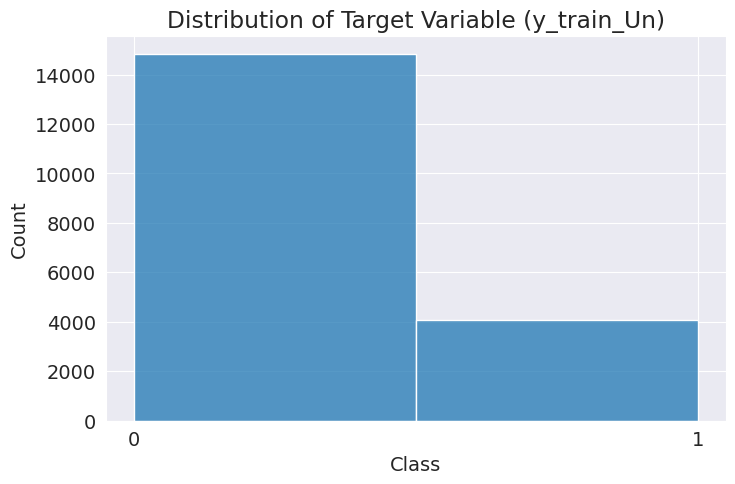

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train_Un, bins=2, kde=False)
plt.title('Distribution of Target Variable (y_train_Un)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

### Create a Pipeline

In [8]:
numeric_cols = Unmodified_df.columns[df.nunique() > 7].tolist()
numeric_cols.remove('loan_percent_income')
numeric_cols

['age',
 'income',
 'years_of_employment',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

In [9]:
categorical_cols = Unmodified_df.columns[Unmodified_df.nunique() <= 7].tolist()
categorical_cols.remove('loan_status')
categorical_cols

['home_ownership_type', 'loan_intent', 'loan_grade', 'default_history']

In [ ]:
pd.set_option('display.max_columns', None)

In [10]:

# Custom transformer for Box-Cox transformation
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting needed
        return self

    def transform(self, X):
        # Ensure X is a DataFrame, converting from NumPy array if necessary
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        # Apply Box-Cox transformation
        transformed = []
        for col in X.columns:
            # Handle non-positive values
            if (X[col] <= 0).any():
                # Use Yeo-Johnson for data that includes negative values or zeros
                transformed_col, _ = stats.yeojohnson(X[col])
            else:
                # Apply Box-Cox directly if all values are positive
                transformed_col, _ = stats.boxcox(X[col])
            transformed.append(transformed_col)

        return pd.DataFrame(np.array(transformed).T, columns=X.columns)

# Split your features into categorical and numerical columns
X_categorical = X_train_Un[categorical_cols]
X_numerical = X_train_Un[numeric_cols]

# Define the transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # In case future data has missing values
    ('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Replace missing values with median
    ('boxcox', BoxCoxTransformer()),  # Custom transformer for Box-Cox
    ('scaler', RobustScaler())  # Normalize using RobustScaler
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numeric_cols)
    ],
    remainder='passthrough'  # Keep any other columns
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit data
pipeline.fit(X_train_Un)

# Transform the data
X_transformed_Un = pipeline.transform(X_train_Un)

# Handling feature names
# Get feature names for categorical columns using OneHotEncoder
cat_features = pipeline.named_steps['preprocessor'].transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Use original numerical column names and include 'loan_percent_income'
num_features = numeric_cols + ['loan_percent_income']  # Ensure loan_percent_income is included

# Combine all feature names
all_features = np.hstack([cat_features, num_features])

# Create DataFrame from transformed data
X_transformed_df = pd.DataFrame(X_transformed_Un, columns=all_features)
X_transformed_df.head()

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.257227,1.016653,0.512118,-0.535221,-0.469875,0.412267,0.04
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.061257,-0.899000,-0.221386,-0.915232,0.023229,-0.322924,0.11
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.227189,0.835674,1.306508,0.535043,-0.373939,0.945870,0.12
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.541498,0.000000,-0.221386,-0.331380,0.701371,-0.825666,0.10
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,-0.949120,-0.830145,0.390596,0.023229,0.000000,0.39


## Training the Model

In [14]:
y_train_Un.values

array([0, 0, 0, ..., 1, 0, 0])

Classifier: DecisionTreeClassifier has a training score of 88.34% accuracy



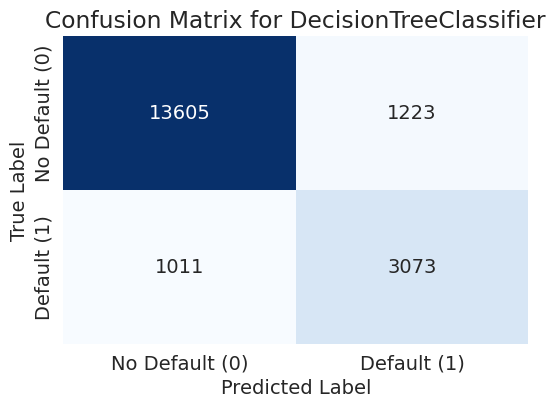


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.92      0.92     14828
     Default       0.72      0.75      0.73      4084

    accuracy                           0.88     18912
   macro avg       0.82      0.83      0.83     18912
weighted avg       0.88      0.88      0.88     18912

Precision: 0.72, Recall: 0.75, F1 Score: 0.73


Classifier: RandomForestClassifier has a training score of 93.15% accuracy



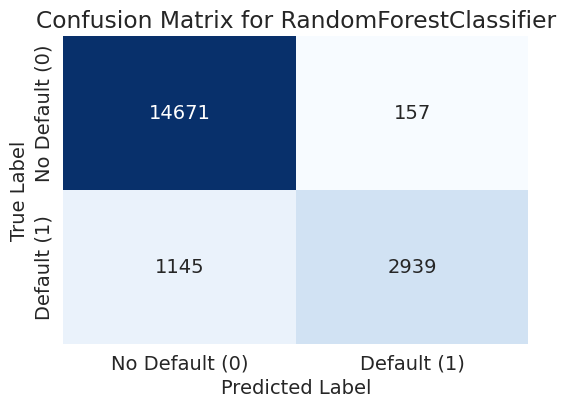


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96     14828
     Default       0.95      0.72      0.82      4084

    accuracy                           0.93     18912
   macro avg       0.94      0.85      0.89     18912
weighted avg       0.93      0.93      0.93     18912

Precision: 0.95, Recall: 0.72, F1 Score: 0.82


Classifier: XGBClassifier has a training score of 93.51% accuracy



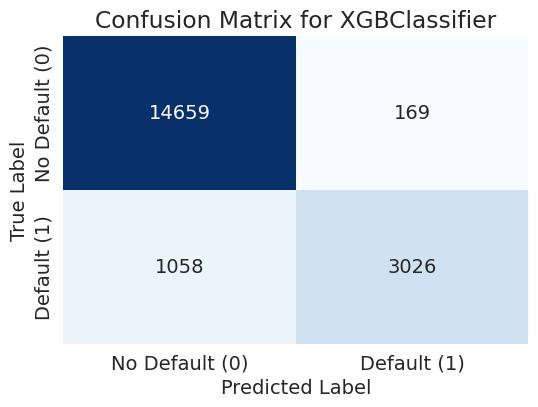


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96     14828
     Default       0.95      0.74      0.83      4084

    accuracy                           0.94     18912
   macro avg       0.94      0.86      0.90     18912
weighted avg       0.94      0.94      0.93     18912

Precision: 0.95, Recall: 0.74, F1 Score: 0.83




In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score


# Define your classifiers (including DecisionTree, RandomForest, and XGBoost)
classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoostClassifier": xgb.XGBClassifier()
}


def plot_confusion_matrix(y_true, y_pred, classifier_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Train the classifiers and evaluate them using confusion matrix, precision, recall, and F1 score
for key, classifier in classifiers.items():
    # Train the model
    classifier.fit(X_transformed_Un, y_train_Un.values)

    # Perform cross-validation predictions for the confusion matrix and metrics
    y_pred = cross_val_predict(classifier, X_transformed_Un, y_train_Un.values, cv=5)

    # Calculate the training score (cross-validation accuracy)
    training_score = cross_val_score(classifier, X_transformed_Un, y_train_Un.values, cv=5)
    print(f"Classifier: {classifier.__class__.__name__} has a training score of {round(training_score.mean() * 100, 2)}% accuracy\n")

    # Plot the confusion matrix using Seaborn
    plot_confusion_matrix(y_train_Un.values, y_pred, classifier.__class__.__name__)

    # Classification report: includes precision, recall, F1-score, and support
    print(f"\nClassification Report for {classifier.__class__.__name__}:")
    print(classification_report(y_train_Un.values, y_pred, target_names=['No Default', 'Default']))

    # Print precision, recall, and F1-score for the Default (1) class
    precision = precision_score(y_train_Un.values, y_pred)
    recall = recall_score(y_train_Un.values, y_pred)
    f1 = f1_score(y_train_Un.values, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("\n" + "="*50 + "\n")


## Grid Seaarch Cross Validation

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

classifiers_param_grids = {
    "DecisionTreeClassifier": (DecisionTreeClassifier(), param_grid_dt),
    "RandomForestClassifier": (RandomForestClassifier(), param_grid_rf),
    "XGBoostClassifier": (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Loop through each classifier and run GridSearchCV
for classifier_name, (classifier, param_grid) in classifiers_param_grids.items():
    print(f"Performing Grid Search for {classifier_name}...")

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_transformed_Un, y_train_Un.values)

    # Print the best parameters and the best score
    print(f"Best parameters for {classifier_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {classifier_name}: {round(grid_search.best_score_ * 100, 2)}%\n")


Performing Grid Search for DecisionTreeClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best cross-validation score for DecisionTreeClassifier: 92.51%

Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for RandomForestClassifier: 93.16%

Performing Grid Search for XGBoostClassifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:57:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoostClassifier: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score for XGBoostClassifier: 93.58%



## Model Validation

In [17]:

X_transformed_val = pipeline.transform(X_val_Un)
X_transformed_val

array([[ 0.        ,  0.        ,  0.        , ..., -0.15827771,
        -0.31672066,  0.09      ],
       [ 0.        ,  0.        ,  1.        , ..., -1.03648903,
         1.16087233,  0.32      ],
       [ 0.        ,  1.        ,  0.        , ..., -0.60553346,
         0.42681494,  0.1       ],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.56678506,
         0.00937181,  0.27      ],
       [ 0.        ,  0.        ,  0.        , ..., -0.81343978,
         0.42681494,  0.12      ],
       [ 0.        ,  0.        ,  1.        , ...,  0.34636749,
         0.00937181,  0.29      ]])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:05:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[4896   46]
 [ 533  829]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4942
           1       0.95      0.61      0.74      1362

    accuracy                           0.91      6304
   macro avg       0.92      0.80      0.84      6304
weighted avg       0.91      0.91      0.90      6304

Precision: 0.95, Recall: 0.61, F1 Score: 0.74


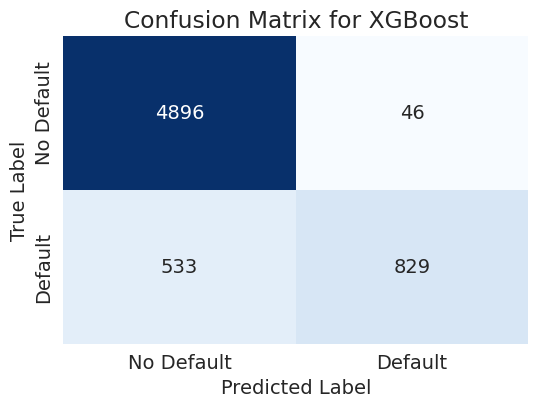

In [19]:
# Best parameters for XGBoost from your Grid Search
best_params_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
}

# Initialize XGBoost with the best parameters
xgb_model = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data (if you haven't done this already)
xgb_model.fit(X_transformed_Un, y_train_Un.values)

# Predict on the validation data
y_val_pred = xgb_model.predict(X_transformed_val)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_Un.values, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_Un.values, y_val_pred))

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_Un.values, y_val_pred)
recall = recall_score(y_val_Un.values, y_val_pred)
f1 = f1_score(y_val_Un.values, y_val_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    plt.title("Confusion Matrix for XGBoost")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix)

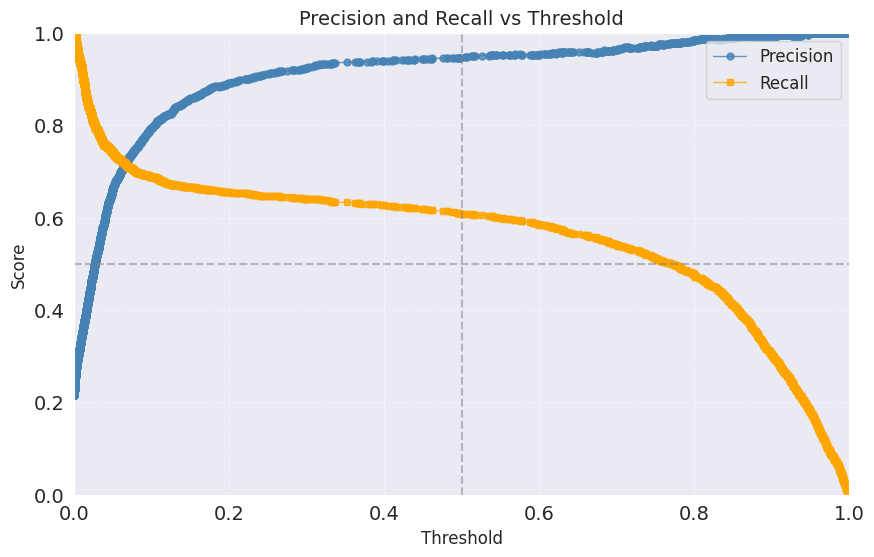

In [20]:
from sklearn.metrics import precision_recall_curve

y_scores = xgb_model.predict_proba(X_transformed_val)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val_Un, y_scores)

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(thresholds, precision[:-1], marker='o', color='steelblue', markersize=5, linewidth=1, alpha=0.8, label='Precision')
plt.plot(thresholds, recall[:-1], marker='s', color='orange', markersize=5, linewidth=1, alpha=0.8, label='Recall')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.grid(linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=12)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Creating a Dataset with Outliers Removed

In [ ]:
Unmodified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31520 entries, 0 to 31519
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         31520 non-null  int64  
 1   income                      31520 non-null  int64  
 2   home_ownership_type         31520 non-null  object 
 3   years_of_employment         31520 non-null  float64
 4   loan_intent                 31520 non-null  object 
 5   loan_grade                  31520 non-null  object 
 6   loan_amnt                   31520 non-null  int64  
 7   loan_int_rate               28494 non-null  float64
 8   loan_percent_income         31520 non-null  float64
 9   default_history             31520 non-null  object 
 10  cb_person_cred_hist_length  31520 non-null  int64  
 11  loan_status                 31520 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


In [21]:
def remove_outliers(df, numerical_cols):
    """
    Removes outliers from specified numerical columns in the DataFrame using the IQR method.

    Parameters:
    - df: pd.DataFrame - The input DataFrame from which to remove outliers.
    - numerical_cols: list - List of column names in the DataFrame to check for outliers.

    Returns:
    - pd.DataFrame - A DataFrame with outliers removed.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    for col in numerical_cols:
        if col in df_cleaned.columns:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1

            # Determine the bounds for non-outlier values
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Filter the DataFrame to remove outliers
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned

In [22]:
numerical_columns = Unmodified_df.columns[df.nunique() > 7].tolist() #This is for this particualar task to include 'percent_loan_income'
numerical_columns

['age',
 'income',
 'years_of_employment',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length']

In [23]:
Outlier_removed_df = remove_outliers(df, numerical_columns)
Outlier_removed_df.head()

,age,income,home_ownership_type,years_of_employment,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,default_history,cb_person_cred_hist_length,loan_status
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,0.25,N,2,1
8,21,10000,OWN,6.0,VENTURE,D,1600,14.74,0.16,N,3,1
18,24,10800,MORTGAGE,8.0,EDUCATION,B,1750,10.99,0.16,N,2,1
22,24,10980,OWN,0.0,PERSONAL,A,1500,7.29,0.14,N,3,0


In [24]:
X_Outlier = Outlier_removed_df.drop('loan_status', axis=1)
y_Outlier = Outlier_removed_df['loan_status']

X_train_out, X_temp_out, y_train_out, y_temp_out = train_test_split(X_Outlier, y_Outlier, test_size=0.4, random_state=42, stratify=y_Outlier)
X_val_out, X_test_out, y_val_out, y_test_out = train_test_split(X_temp_out, y_temp_out, test_size=0.5, random_state=42, stratify=y_temp_out)

In [25]:
print(X_train_out.shape)
print(y_train_out.shape)
y_train_out.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'

(13778, 11)
(13778,)


,proportion
loan_status,
0,79.91%
1,20.09%


## Preparing the data for Algorithims

In [26]:
pipeline.fit(X_train_out)

# Transform the data
X_transformed_out = pipeline.transform(X_train_out)

# Handling feature names
# Get feature names for categorical columns using OneHotEncoder
cat_features = pipeline.named_steps['preprocessor'].transformers_[0][1] \
    .named_steps['onehot'].get_feature_names_out(categorical_cols)

# Use original numerical column names and include 'loan_percent_income'
num_features = numeric_cols + ['loan_percent_income']  # Ensure loan_percent_income is included

# Combine all feature names
all_features = np.hstack([cat_features, num_features])

# Create DataFrame from transformed data
X_transformed_out_df = pd.DataFrame(X_transformed_out, columns=all_features)
X_transformed_out_df.head()

,home_ownership_type_OTHER,home_ownership_type_OWN,home_ownership_type_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,default_history_Y,age,income,years_of_employment,loan_amnt,loan_int_rate,cb_person_cred_hist_length,loan_percent_income
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.480020,0.382454,-1.225470,-1.564164,-0.711655,-0.363294,0.01
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.067977,0.191934,-0.218427,-0.075083,0.652007,0.776034,0.10
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.195615,-0.365231,-1.225470,-0.512925,0.085592,-0.363294,0.11
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.655166,0.382454,1.290706,-0.453358,0.021116,0.998826,0.07
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.367763,1.351203,-0.473710,0.459387,0.290240,0.470029,0.09


Classifier: DecisionTreeClassifier has a training score of 87.8% accuracy



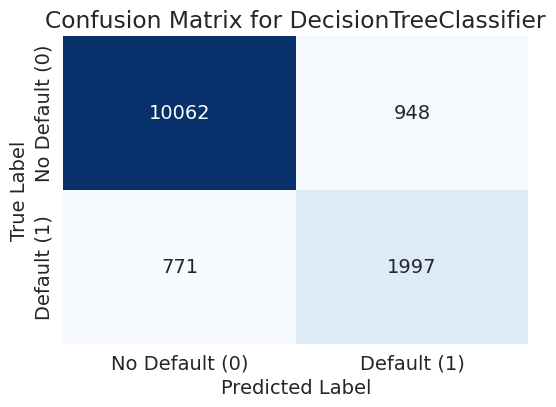


Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.91      0.92     11010
     Default       0.68      0.72      0.70      2768

    accuracy                           0.88     13778
   macro avg       0.80      0.82      0.81     13778
weighted avg       0.88      0.88      0.88     13778

Precision: 0.68, Recall: 0.72, F1 Score: 0.70


Classifier: RandomForestClassifier has a training score of 92.87% accuracy



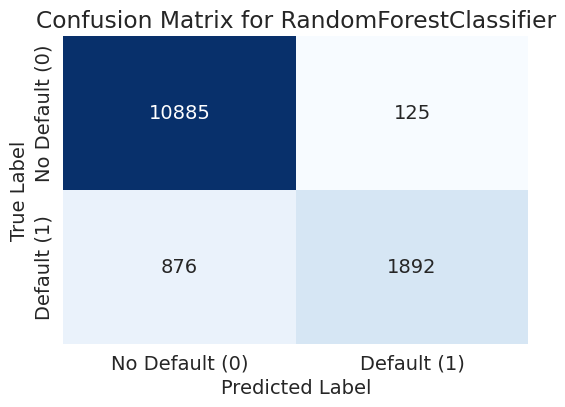


Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96     11010
     Default       0.94      0.68      0.79      2768

    accuracy                           0.93     13778
   macro avg       0.93      0.84      0.87     13778
weighted avg       0.93      0.93      0.92     13778

Precision: 0.94, Recall: 0.68, F1 Score: 0.79


Classifier: XGBClassifier has a training score of 93.16% accuracy



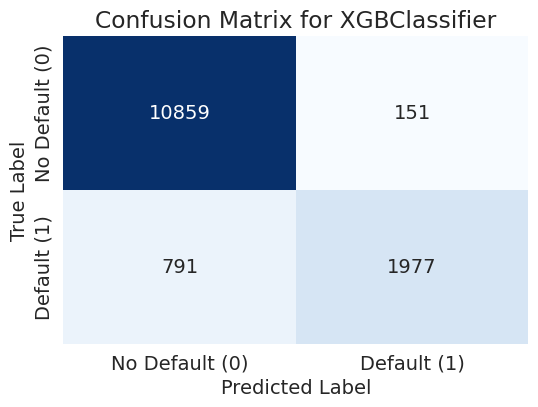


Classification Report for XGBClassifier:
              precision    recall  f1-score   support

  No Default       0.93      0.99      0.96     11010
     Default       0.93      0.71      0.81      2768

    accuracy                           0.93     13778
   macro avg       0.93      0.85      0.88     13778
weighted avg       0.93      0.93      0.93     13778

Precision: 0.93, Recall: 0.71, F1 Score: 0.81




In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score


# Define your classifiers (including DecisionTree, RandomForest, and XGBoost)
classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoostClassifier": xgb.XGBClassifier()
}


def plot_confusion_matrix(y_true, y_pred, classifier_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default (0)", "Default (1)"], yticklabels=["No Default (0)", "Default (1)"])
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Train the classifiers and evaluate them using confusion matrix, precision, recall, and F1 score
for key, classifier in classifiers.items():
    # Train the model
    classifier.fit(X_transformed_out, y_train_out.values)

    # Perform cross-validation predictions for the confusion matrix and metrics
    y_pred = cross_val_predict(classifier, X_transformed_out, y_train_out.values, cv=5)

    # Calculate the training score (cross-validation accuracy)
    training_score = cross_val_score(classifier, X_transformed_out, y_train_out.values, cv=5)
    print(f"Classifier: {classifier.__class__.__name__} has a training score of {round(training_score.mean() * 100, 2)}% accuracy\n")

    # Plot the confusion matrix using Seaborn
    plot_confusion_matrix(y_train_out.values, y_pred, classifier.__class__.__name__)

    # Classification report: includes precision, recall, F1-score, and support
    print(f"\nClassification Report for {classifier.__class__.__name__}:")
    print(classification_report(y_train_out.values, y_pred, target_names=['No Default', 'Default']))

    # Print precision, recall, and F1-score for the Default (1) class
    precision = precision_score(y_train_out.values, y_pred)
    recall = recall_score(y_train_out.values, y_pred)
    f1 = f1_score(y_train_out.values, y_pred)

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
    print("\n" + "="*50 + "\n")


In [28]:
from sklearn.model_selection import GridSearchCV

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

classifiers_param_grids = {
    "DecisionTreeClassifier": (DecisionTreeClassifier(), param_grid_dt),
    "RandomForestClassifier": (RandomForestClassifier(), param_grid_rf),
    "XGBoostClassifier": (xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb)
}

# Loop through each classifier and run GridSearchCV
for classifier_name, (classifier, param_grid) in classifiers_param_grids.items():
    print(f"Performing Grid Search for {classifier_name}...")

    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_transformed_out, y_train_out.values)

    # Print the best parameters and the best score
    print(f"Best parameters for {classifier_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {classifier_name}: {round(grid_search.best_score_ * 100, 2)}%\n")


Performing Grid Search for DecisionTreeClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Best cross-validation score for DecisionTreeClassifier: 92.47%

Performing Grid Search for RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for RandomForestClassifier: 92.92%

Performing Grid Search for XGBoostClassifier...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:24:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoostClassifier: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score for XGBoostClassifier: 93.37%



In [29]:
X_transformed_val_out = pipeline.transform(X_val_out)
X_transformed_val_out

array([[ 0.        ,  0.        ,  1.        , ...,  0.19002194,
        -0.92309736,  0.11      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.09109703,
         0.98370843,  0.05      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.00957163,
         0.62527848,  0.13      ],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.12966663,
        -0.00634548,  0.07      ],
       [ 0.        ,  0.        ,  1.        , ..., -0.14145391,
        -0.92309736,  0.32      ],
       [ 0.        ,  0.        ,  0.        , ..., -0.11587959,
        -0.92309736,  0.1       ]])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:30:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
[[3469  201]
 [ 288  635]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3670
           1       0.76      0.69      0.72       923

    accuracy                           0.89      4593
   macro avg       0.84      0.82      0.83      4593
weighted avg       0.89      0.89      0.89      4593

Precision: 0.76, Recall: 0.69, F1 Score: 0.72


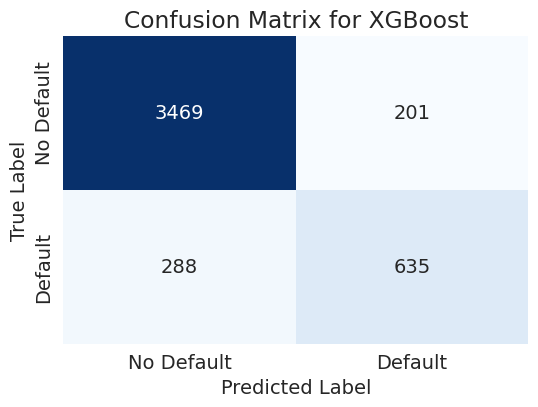

In [30]:
best_params_xgb = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.2,
    'max_depth': 6,
    'n_estimators': 100,
    'subsample': 1.0,
}

# Initialize XGBoost with the best parameters
xgb_model_2 = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss')

# Fit the model on the training data (if you haven't done this already)
xgb_model_2.fit(X_transformed_out, y_train_out.values)

# Predict on the validation data
y_val_pred = xgb_model_2.predict(X_transformed_val_out)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_out.values, y_val_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_out.values, y_val_pred))

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_out.values, y_val_pred)
recall = recall_score(y_val_out.values, y_val_pred)
f1 = f1_score(y_val_out.values, y_val_pred)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
    plt.title("Confusion Matrix for XGBoost")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix)

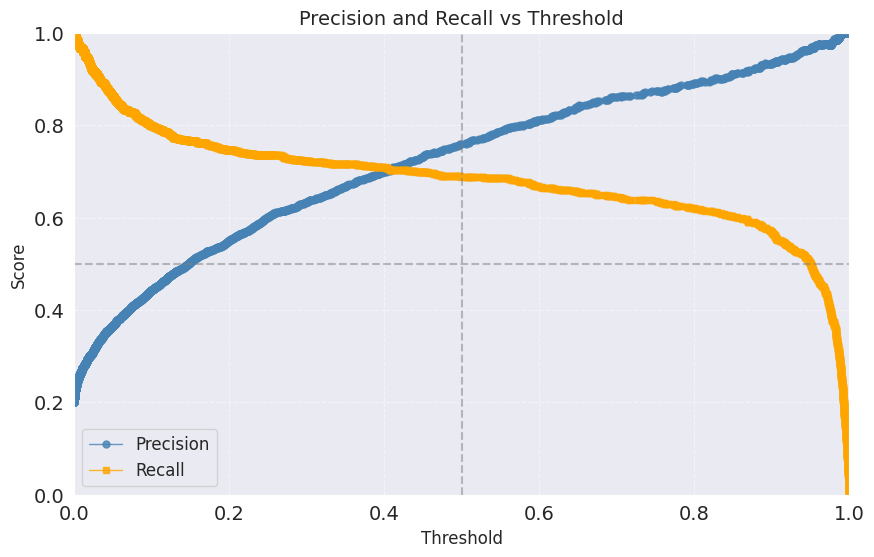

In [31]:
from sklearn.metrics import precision_recall_curve

y_scores = xgb_model_2.predict_proba(X_transformed_val_out)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_val_out, y_scores)

plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(thresholds, precision[:-1], marker='o', color='steelblue', markersize=5, linewidth=1, alpha=0.8, label='Precision')
plt.plot(thresholds, recall[:-1], marker='s', color='orange', markersize=5, linewidth=1, alpha=0.8, label='Recall')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision and Recall vs Threshold', fontsize=14)
plt.grid(linestyle='--', alpha=0.5)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=12)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

## Adjusting Threshold

In [32]:
def plot_metrics_and_confusion_matrix(model, X_val, y_val, start=0.1, stop=0.9, step=0.05, specific_threshold=None):
    # Get predicted probabilities for the positive class (1)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Define a range of threshold values
    thresholds = np.arange(start, stop, step)

    # Initialize lists to store precision and recall scores at each threshold
    precision_scores = []
    recall_scores = []

    # Loop through each threshold to calculate scores
    for threshold in thresholds:
        # Get binary predictions based on the threshold
        y_val_pred_threshold = (y_val_proba >= threshold).astype(int)

        # Calculate precision and recall
        precision = precision_score(y_val, y_val_pred_threshold)
        recall = recall_score(y_val, y_val_pred_threshold)

        # Append scores to lists
        precision_scores.append(precision)
        recall_scores.append(recall)

    # Plot Precision and Recall vs Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision', marker='o', color='blue')
    plt.plot(thresholds, recall_scores, label='Recall', marker='o', color='green')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()  # Separate the precision/recall plot from the confusion matrix plot

    # Show performance metrics and confusion matrix for specific threshold
    if specific_threshold is not None:
        y_val_pred_specific = (y_val_proba >= specific_threshold).astype(int)

        # Calculate metrics
        precision = precision_score(y_val, y_val_pred_specific)
        recall = recall_score(y_val, y_val_pred_specific)
        f1 = f1_score(y_val, y_val_pred_specific)

        print(f"\nPerformance metrics at threshold {specific_threshold}:")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print("\nClassification Report:")
        print(classification_report(y_val, y_val_pred_specific))

        # Display confusion matrix
        conf_matrix = confusion_matrix(y_val, y_val_pred_specific)
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
        plt.title(f"Confusion Matrix at Threshold = {specific_threshold}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

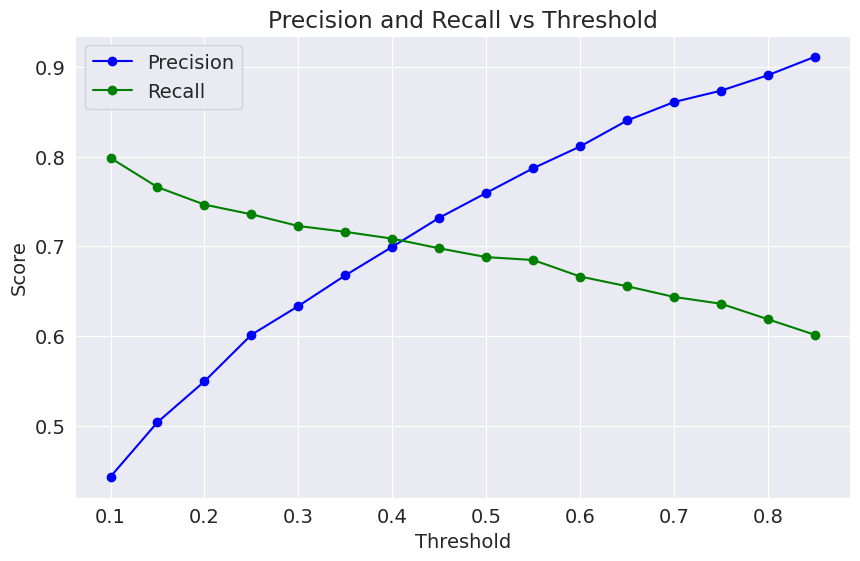


Performance metrics at threshold 0.2:
Precision: 0.55
Recall: 0.75
F1 Score: 0.63

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      3670
           1       0.55      0.75      0.63       923

    accuracy                           0.83      4593
   macro avg       0.74      0.80      0.76      4593
weighted avg       0.85      0.83      0.84      4593



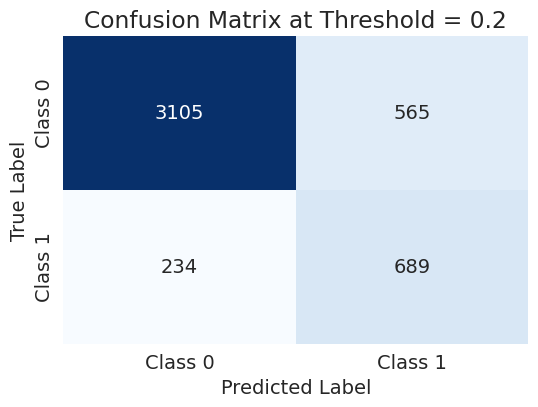

In [33]:
plot_metrics_and_confusion_matrix(xgb_model_2, X_transformed_val_out, y_val_out.values, specific_threshold=0.20)

In [34]:
X_transformed_test_out = pipeline.transform(X_test_out)
X_transformed_test_out

array([[ 0.        ,  1.        ,  0.        , ...,  0.66952189,
         0.27710617,  0.03      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.34282062,
        -0.9186176 ,  0.19      ],
       [ 0.        ,  0.        ,  0.        , ..., -0.77241201,
         0.79558251,  0.21      ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.02896078,
        -0.35692815,  0.27      ],
       [ 0.        ,  0.        ,  0.        , ..., -0.02346043,
         0.91659468,  0.1       ],
       [ 0.        ,  1.        ,  0.        , ..., -0.16117378,
        -0.9186176 ,  0.06      ]])

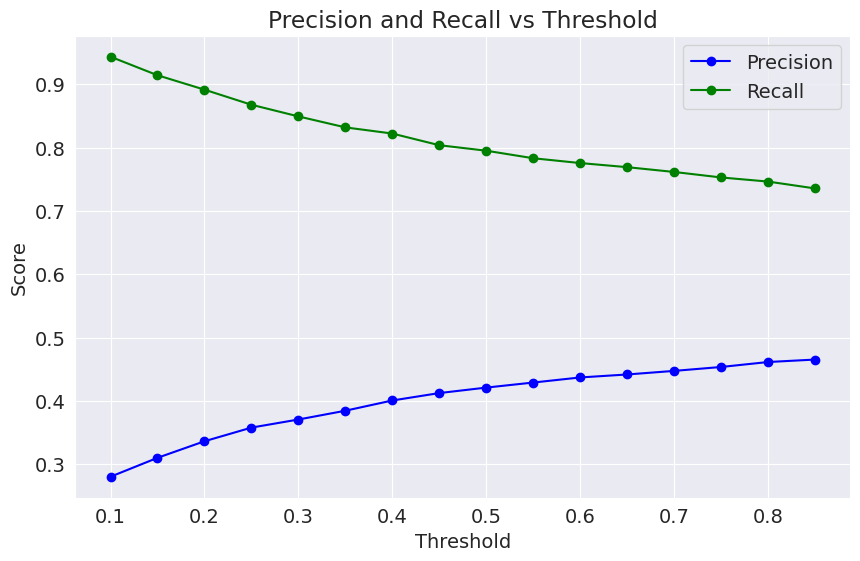


Performance metrics at threshold 0.2:
Precision: 0.34
Recall: 0.89
F1 Score: 0.49

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.56      0.70      3670
           1       0.34      0.89      0.49       923

    accuracy                           0.62      4593
   macro avg       0.64      0.72      0.60      4593
weighted avg       0.83      0.62      0.66      4593



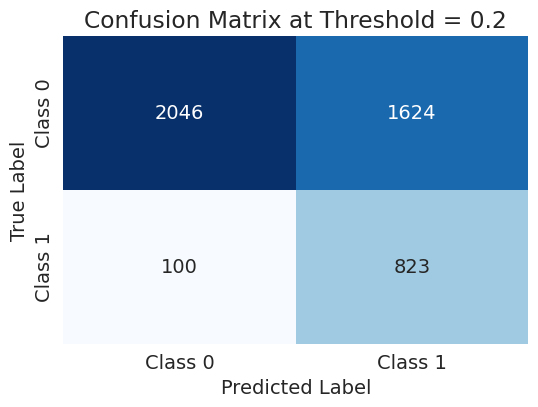

In [36]:
plot_metrics_and_confusion_matrix(xgb_model_2, X_transformed_test_out, y_test_out.values, specific_threshold=0.20)